Mean Absolute Error (Linear Regression): 3.2772891402954274
Mean Absolute Error (Random Forest Regression): 3.075688311688311
Mean Absolute Error (XGBoost Regression): 3.074175272204659


Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_df['Playoff Wins (Random Forest Regression)'] = rfr_predicted_wins
C:\Users\Archana\AppData\Local\Temp\ipykernel_15440\1092134198.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_df['Playoff Wins (XGBoost Regression)'] = xgb_predicted_wins


,Team,Playoff Wins,Playoff Wins (Linear Regression),Playoff Wins (Random Forest Regression),Playoff Wins (XGBoost Regression)
0,Milwaukee Bucks,NaN,10.129623,12.114286,12.139861
1,Toronto Raptors,NaN,9.122012,9.277143,8.033976
2,Boston Celtics,NaN,7.859166,7.011429,6.099645
3,Miami Heat,NaN,8.956236,5.522857,5.427671
4,Indiana Pacers,NaN,3.746157,1.954286,2.038069
5,Philiadelphia 76ers,NaN,3.240059,1.914286,1.565095
6,Brooklyn Nets,NaN,4.018373,2.060000,3.600355
7,Orlando Magic,NaN,-0.684165,1.825714,1.290382
8,Washington Wizards,NaN,-4.833770,1.842857,2.205480
9,Los Angeles Lakers,NaN,10.066506,10.202857,9.885896


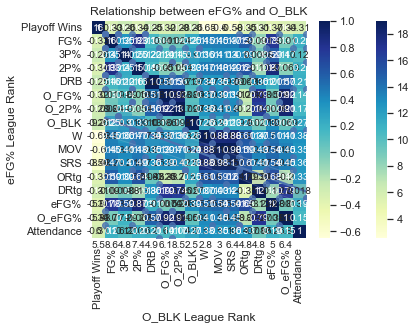

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
from xgboost import XGBRegressor

# Set the plotting environment
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
%matplotlib inline

# Read the data
data = pd.read_csv('past_league_rankings.csv')
pred_data = pd.read_csv('2020_league_rankings_before_orlando.csv')

# Drop unnecessary columns
drop_cols = ['Rk', 'O_MP', 'L', 'PW', 'PL', 'Arena']
data = data.drop(columns=drop_cols).rename(columns={'eFG%.1': 'O_eFG%', 'TOV%.1': 'O_TOV%', 'FT/FGA.1': 'O_FT/FGA'})
pred_data = pred_data.drop(columns=drop_cols).rename(columns={'eFG%.1': 'O_eFG%', 'TOV%.1': 'O_TOV%'})

# Define variables with medium correlation with playoff wins
corr = data.corr().abs()
variables = list(corr.loc[corr['Playoff Wins'] > 0.25].index)

# Visualizations and analysis
corr_df = data[variables].groupby('Playoff Wins').mean()
sns.heatmap(data=corr_df, annot=True, cmap="YlGnBu")
plt.xlabel("Regular Season Stat Rankings")
plt.title("Average League Ranking in Each Category, by Playoff Wins")

sns.heatmap(data=data[variables].corr(), annot=True, cmap="YlGnBu")
plt.title("Correlation between Filtered Variables")

sns.regplot(x=data['O_BLK'], y=data['eFG%'], label='eFG%')
plt.xlabel("O_BLK League Rank")
plt.ylabel("eFG% League Rank")
plt.title("Relationship between eFG% and O_BLK")

# Data splitting
X = data[variables].drop('Playoff Wins', 1)
y = data['Playoff Wins']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

# Linear Regression model
lg_model = linear_model.LinearRegression()
lg_model.fit(X_train, y_train)
lg_model_predicted_wins = lg_model.predict(X_valid)
print("Mean Absolute Error (Linear Regression):", mean_absolute_error(lg_model_predicted_wins, y_valid))

# Random Forest Regression model
rfr_model = RandomForestRegressor(n_estimators=350, random_state=0)
rfr_model.fit(X_train, y_train)
rfr_predicted_wins = rfr_model.predict(X_valid)
print("Mean Absolute Error (Random Forest Regression):", mean_absolute_error(rfr_predicted_wins, y_valid))

# XGBoost Regression model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05)
xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_valid, y_valid)], verbose=False)
xgb_predicted_wins = xgb_model.predict(X_valid)
print("Mean Absolute Error (XGBoost Regression):", mean_absolute_error(xgb_predicted_wins, y_valid))

# Prediction on new data
pred_X = pred_data[variables].drop('Playoff Wins', 1)
lg_model_predicted_wins = lg_model.predict(pred_X)
rfr_predicted_wins = rfr_model.predict(pred_X)
xgb_predicted_wins = xgb_model.predict(pred_X)

# Create prediction dataframe
predictions_df = pred_data[['Team', 'Playoff Wins']]
predictions_df['Playoff Wins (Linear Regression)'] = lg_model_predicted_wins
predictions_df['Playoff Wins (Random Forest Regression)'] = rfr_predicted_wins
predictions_df['Playoff Wins (XGBoost Regression)'] = xgb_predicted_wins
predictions_df = predictions_df.sort_values(by='Playoff Wins', ascending=False)

predictions_df
